In [1]:
%matplotlib inline

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
df = pd.read_csv('Data for Forecast.csv', decimal=",")
df.head()

,year,month,Sales
0,2009,1,44265939.13
1,2009,3,54900710.11
2,2009,2,55917784.58
3,2009,4,59119663.88
4,2009,5,60949016.31


In [5]:
df['Date'] = pd.period_range(start='2009-01', end='2019-11', freq='M')
df.index = df['Date']
df = df.drop(['year', 'month', 'Date'], axis=1)
df.head()

,Sales
Date,
2009-01,44265939.13
2009-02,54900710.11
2009-03,55917784.58
2009-04,59119663.88
2009-05,60949016.31


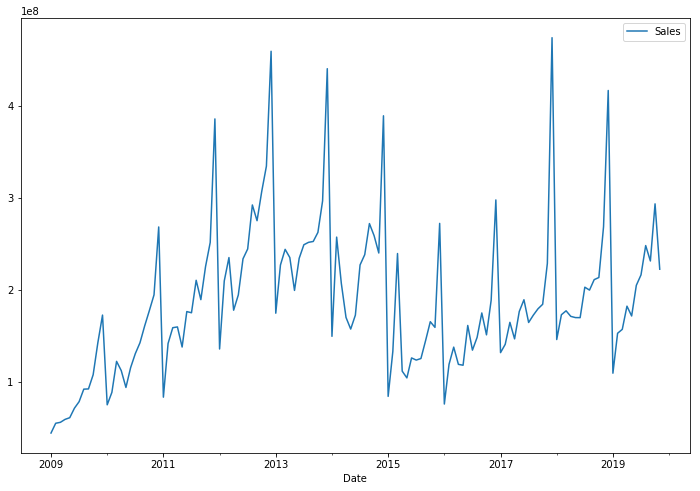

In [6]:
df.plot(figsize=(12,8));

Критерий Дики-Фуллера: p=0.172392


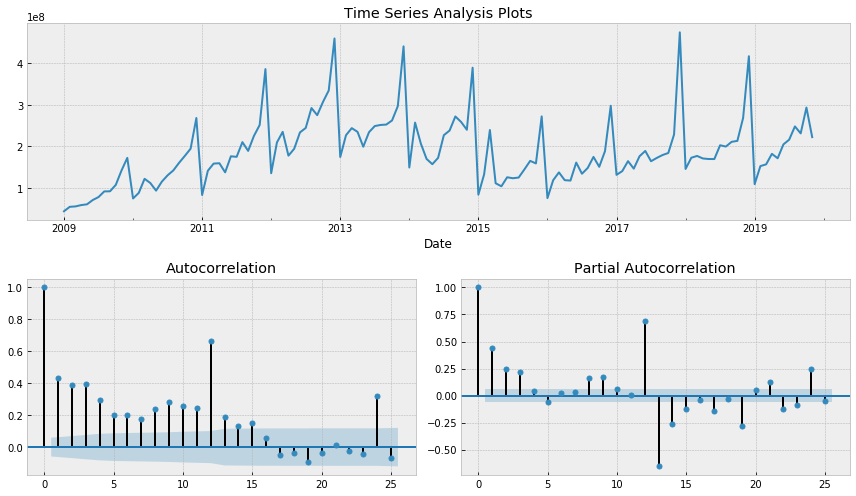

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df.Sales, lags=25)

Критерий Дики-Фуллера: p=0.135993
Оптимальный параметр преобразования Бокса-Кокса: 0.301832


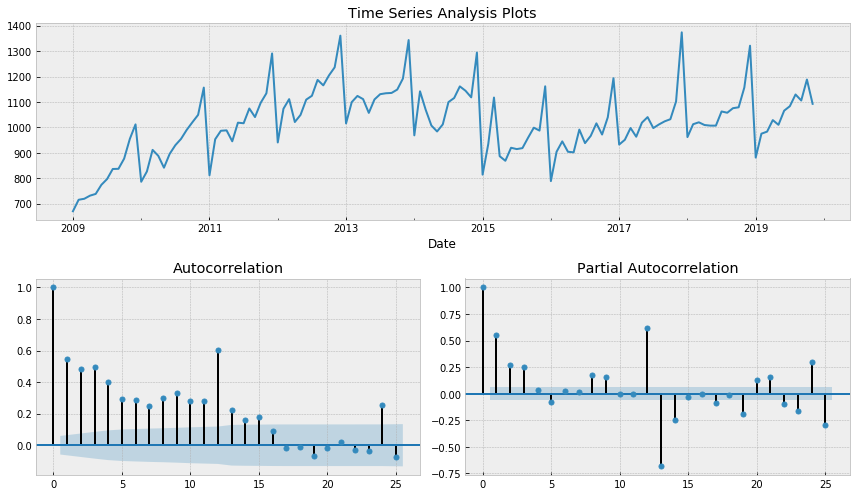

In [9]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y)/lmbda))

data = df.copy()
data['Sales_box'], lmbda = scs.boxcox(data.Sales)
tsplot(data.Sales_box, lags=25)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.335821


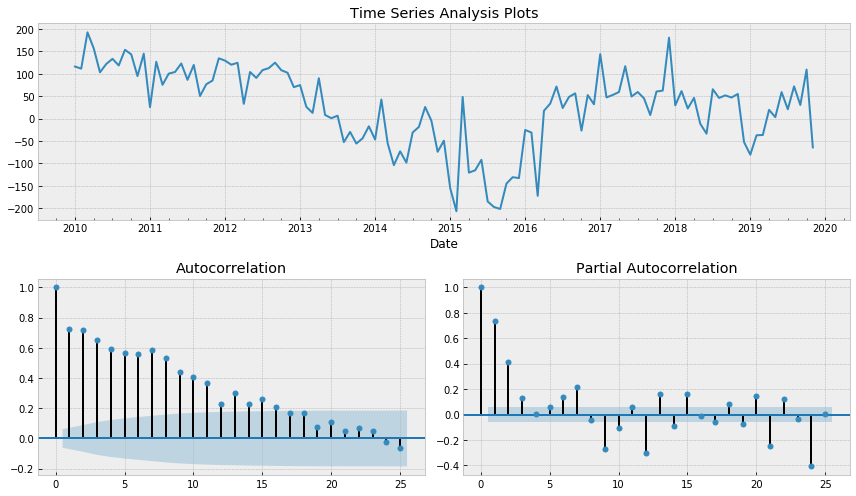

In [11]:
data['Sales_box_season'] = data.Sales_box - data.Sales_box.shift(12)
tsplot(data.Sales_box_season[12:], lags=25)

Критерий Дики-Фуллера: p=0.040507


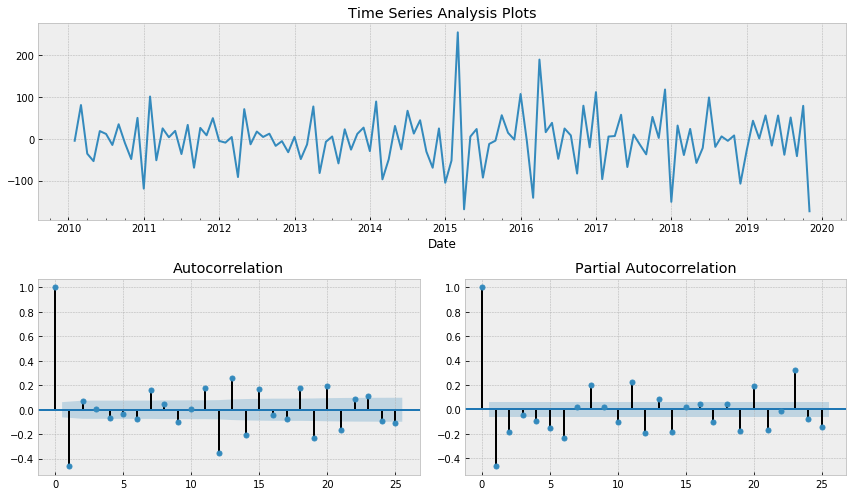

In [34]:
data['Sales_box_season_diff'] = data.Sales_box_season - data.Sales_box_season.shift(1)
tsplot(data.Sales_box_season_diff[12+1:], lags=25)

In [38]:
test = sm.tsa.adfuller(data.Sales_box_season_diff[12+1:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')


adf:  -2.9436053690938313
p-value:  0.04050720243646434
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
единичных корней нет, ряд стационарен


Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, не забыв, что предварительно уже сделали первые и сезонные разности.

In [35]:
ps = range(0, 5)
d=2
qs = range(0, 4)
Ps = range(0, 5)
D=2
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [36]:
%%time
results = []
best_aic = float("inf")

for param in log_progress(parameters_list, every=5):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=False)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


      parameters          aic
14  (0, 2, 4, 0)  1185.197642
34  (1, 2, 4, 0)  1186.965338
19  (0, 3, 4, 0)  1187.040046
49  (2, 1, 4, 0)  1188.305712
39  (1, 3, 4, 0)  1189.072247
Wall time: 10min 18s


In [31]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Sales_box, order=(1, d, 3), 
                                        seasonal_order=(4, D, 0, 12)).fit(disp=False)
print(best_model.summary())

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                 
Dep. Variable:                          Sales_box   No. Observations:                  131
Model:             SARIMAX(1, 2, 3)x(4, 2, 0, 12)   Log Likelihood                -585.536
Date:                            Mon, 20 Jan 2020   AIC                           1189.072
Time:                                    02:35:56   BIC                           1212.958
Sample:                                01-31-2009   HQIC                          1198.751
                                     - 11-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9912      0.253     -3.916      0.000      -1.487      -0.495
ma.L1         -0.5971     24.397   

Критерий Дики-Фуллера: p=0.000000


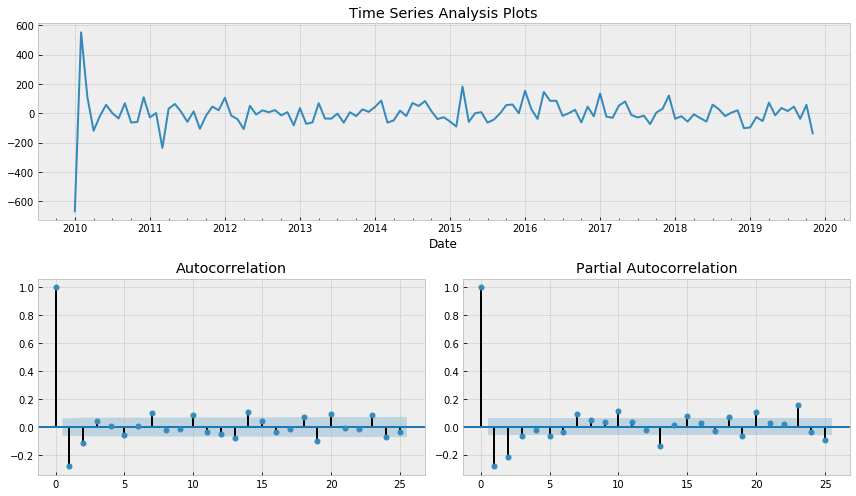

In [32]:
tsplot(best_model.resid[12:], lags=25)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


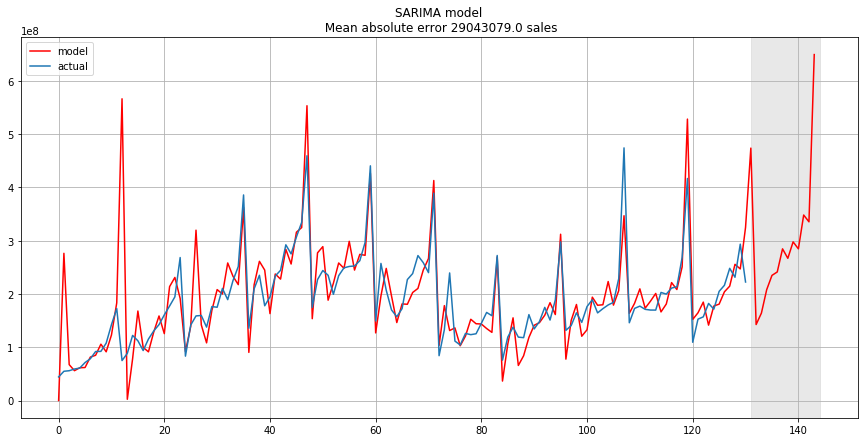

In [33]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+12), lmbda)
forecast = data.arima_model.append(forecast).values
actual = df.Sales.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} sales".format(round(mean_absolute_error(data.dropna().Sales, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)